In [1]:
import os
# training area of DC1 SKA simulated Map. Compare position of sources in the original map and the recovered map, And Flux recovery.
PATH_SKADC1_TRAINING = '/Users/rs17612/Documents/Radio_Data/SKA_Challenge_1/SKAMID_B1_1000h_v3_cropped.fits'
PATH_SKADC1_FULL = '/Users/rs17612/Documents/Radio_Data/SKA_Challenge_1/SKAMID_B1_1000h_v3.fits'
# function to test if the file exists
def file_exists(path):
    if os.path.isfile(path):
        print('File exists : '+path)
        return True
    else:
        print('File does not exist : '+path)
        return False
    
file_exists(PATH_SKADC1_TRAINING)
file_exists(PATH_SKADC1_FULL)

File exists : /Users/rs17612/Documents/Radio_Data/SKA_Challenge_1/SKAMID_B1_1000h_v3_cropped.fits
File exists : /Users/rs17612/Documents/Radio_Data/SKA_Challenge_1/SKAMID_B1_1000h_v3.fits


True

   
###########################
 _____   ___    ___    ___ 
|_   _| | _ \  / __|  | __|
  | |   |   /  \__ \  | _| 
  |_|   |_|_\  |___/  |_|  
        
###########################
Topological Radio Source Finder.
        
-------------------
Starting TRSF
NOTICE: Image path: /Users/rs17612/Documents/Radio_Data/SKA_Challenge_1/SKAMID_B1_1000h_v3_cropped.fits
Attempting to open Image...
NOTICE: Input Image Size (3198, 3490)
NOTICE: Image Size with reduced padding (3198, 3490)
Calculating persistence diagrams and source properties..


Cutouts Completed: 100%|██████████| 182/182 [07:39<00:00,  2.53s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


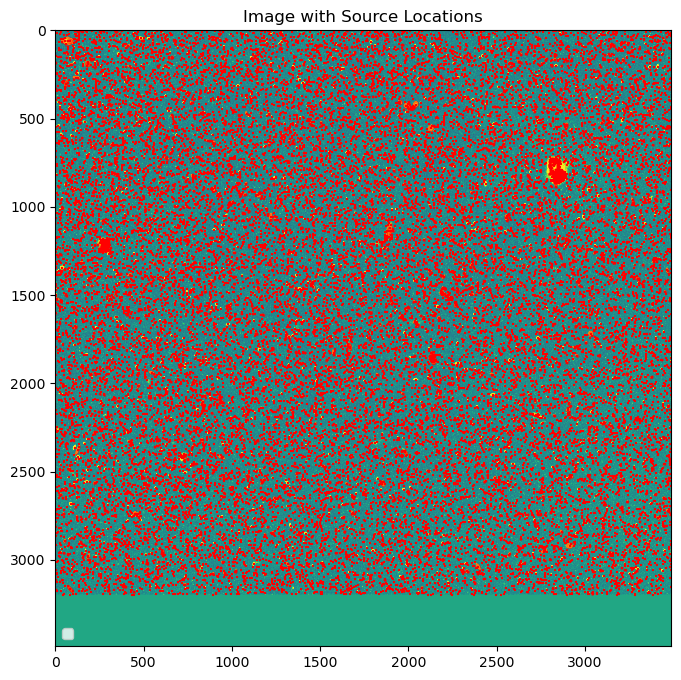

TRSF finished.
Time taken: 466.9048252105713 seconds
-------------------


In [2]:
from TRSF import trsf
import numpy as np 
import matplotlib.pyplot as plt

SKA_DC1_TRSF = trsf(PATH_SKADC1_TRAINING,gaussian_fitting=True)

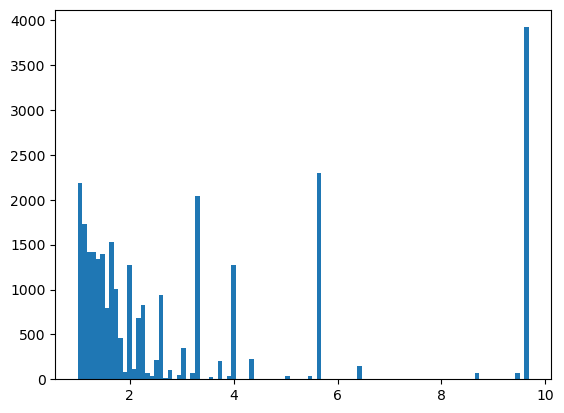

In [3]:
SKA_DC1_TRSF.correctionf_list
plt.hist(SKA_DC1_TRSF.correctionf_list,bins=100)
plt.show()

In [4]:
from astropy.stats import mad_std

print(len(SKA_DC1_TRSF.catalogue))
local_bg = mad_std(SKA_DC1_TRSF.full_img, ignore_nan=True)
print('local_bg', local_bg)

30933
local_bg 3.4864351509170494e-07


In [5]:
import skimage.measure as measure

def get_enclosing_mask(x, y, mask):
    '''
    Returns the mask of the enclosed area of the point (x,y) in the mask.
    '''
    
    # Ensure the point is inside the mask
    if not mask[y, x]:
        return None
    # Create a copy of the mask
    enclosed_mask = np.copy(mask)
    # Perform a flood fill starting from the point
    h, w = mask.shape
    stack = [(x, y)]
    while stack:
        x, y = stack.pop()
        if enclosed_mask[y, x]:
            enclosed_mask[y, x] = False
            if x > 0:
                stack.append((x - 1, y))
            if x < w - 1:
                stack.append((x + 1, y))
            if y > 0:
                stack.append((x, y - 1))
            if y < h - 1:
                stack.append((x, y + 1))
    
    return mask & (~enclosed_mask)

def plottings(cat,ptype,color,img,row=False):
    
    label = False
    for i in range(0,len(cat)):
        row = cat.iloc[i]
        if ptype=='bbox':
            bbox = row.bbox
            if bbox != None:
                xmin = bbox[0] - 1
                xmax = bbox[2] + 1
                ymin = bbox[1] - 1
                ymax = bbox[3] + 1
                if label == False:
                    plt.plot([ymin,ymin,ymax,ymax,ymin],[xmin,xmax,xmax,xmin,xmin],color=color,label='class 5')
                    label = True
                plt.plot([ymin,ymin,ymax,ymax,ymin],[xmin,xmax,xmax,xmin,xmin],color=color)
        if ptype == 'point':
            plt.plot(row.y,row.x,'+',color=color)
        
        if ptype == 'polygonwith':
            polygon = row.polygon
            try:
                if label == False:
                    plt.plot(polygon[:,1],polygon[:,0],color=color,label='class 2')
                    label = True
                else:
                    plt.plot(polygon[:,1],polygon[:,0],color=color)  
            except:
                #print('polygonwith Failed')
                continue
                #plottings(cat,'polygonwithout',color,img) 
                
        if ptype == 'polygonwithout':
        # we much create the polygons from the birth and death points
            try:
                birth = row.Birth
                death = row.Death
                mask = np.zeros(img.shape)
                mask = np.logical_or(mask, np.logical_and(img <= birth, img > death))
                #print(row.x_c,row.y_c)
                
                mask = get_enclosing_mask(int(row.x_c),int(row.y_c),mask)
                mask = mask.astype(int)

                contour = measure.find_contours(mask)[0]

                if label == False:
                    plt.plot(contour[:,1],contour[:,0],color=color,label='class 2')
                    label= True
                else:
                    plt.plot(contour[:,1],contour[:,0],color=color)   
            except:
                print(row)

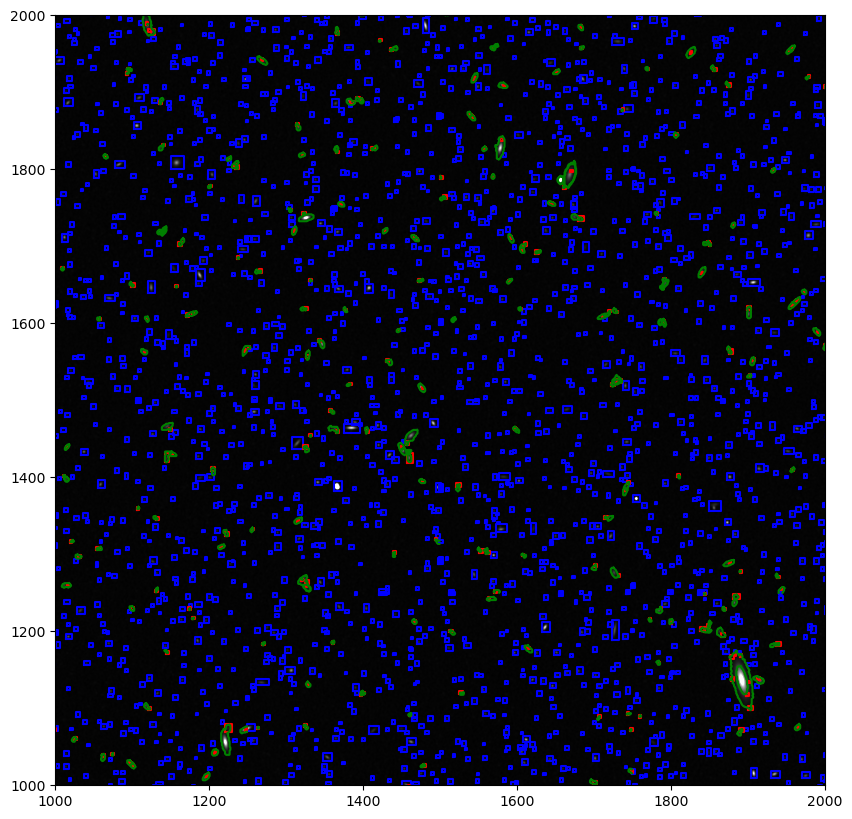

In [6]:
import matplotlib.pyplot as plt
image = SKA_DC1_TRSF.full_img
catalogue = SKA_DC1_TRSF.catalogue
catalogue['Class'][np.isnan(catalogue['Class'])] = 2
cat0 = catalogue[catalogue['Class'] == 0]
cat1 = catalogue[catalogue['Class'] == 1]
cat2 = catalogue[catalogue['Class'] == 2]
cat3 = catalogue[catalogue['Class'] == 3]
plt.figure(figsize=(10,10))
plt.imshow(image,origin='lower',cmap='gray',vmax=0.0001)
plottings(cat0,'bbox',color='b',img=image)
plottings(cat1,'bbox',color='r',img=image)
plottings(cat2,'polygonwith',color='g',img=image)
plottings(cat3,'bbox',color='y',img=image)
#plottings(cat4,'polygonwithout',color='m',img=image)
#plottings(cat5,'polygonwithout',color='c',img=image)
plt.xlim(1000,2000)
plt.ylim(1000,2000)
plt.show()

In [7]:
# open training data
PATH_training_SKA = '/Users/rs17612/Documents/Radio_Data/SKA_Challenge_1/TrainingSet_B1_v2.txt'

# open txt. file where elements are separated by a different number of spaces
import pandas as pd

training_catalogue = pd.read_csv(PATH_training_SKA, sep='\s+', header=None)
# drop the first row
training_catalogue = training_catalogue.drop([0], axis=0)
# drop last 5 columns
training_catalogue = training_catalogue.drop([15,16,17,18,19], axis=1)
# rename columns
training_catalogue.columns = ['ID','RA_core','DEC_core','RA_centroid','DEC_centroid','FLUX_Tot_corr','Core_Frac','BMAJ','BMIN','PA','SIZE','CLASS','SELECTION','x','y']
# set correct datatypes to catalogue

training_catalogue['ID'] = training_catalogue['ID'].astype('int')
training_catalogue['RA_core'] = training_catalogue['RA_core'].astype('float')
training_catalogue['DEC_core'] = training_catalogue['DEC_core'].astype('float')
training_catalogue['RA_centroid'] = training_catalogue['RA_centroid'].astype('float')
training_catalogue['DEC_centroid'] = training_catalogue['DEC_centroid'].astype('float')
training_catalogue['FLUX_Tot_corr'] = training_catalogue['FLUX_Tot_corr'].astype('float')
training_catalogue['Core_Frac'] = training_catalogue['Core_Frac'].astype('float')
training_catalogue['BMAJ'] = training_catalogue['BMAJ'].astype('float')
training_catalogue['BMIN'] = training_catalogue['BMIN'].astype('float')
training_catalogue['PA'] = training_catalogue['PA'].astype('float')
training_catalogue['SIZE'] = training_catalogue['SIZE'].astype('float')
training_catalogue['CLASS'] = training_catalogue['CLASS'].astype('int')
training_catalogue['SELECTION'] = training_catalogue['SELECTION'].astype('int')
training_catalogue['x'] = training_catalogue['x'].astype('float')
training_catalogue['y'] = training_catalogue['y'].astype('float')

from astropy.io import fits

def convert_arcsec_to_pixels(Image_PATH,spacial_width,header=None):
    '''Convert arcsec widths to pixels numbers.'''
    # Load the image header
    if header == None:
        print('Loading the image header')
        header = fits.open(Image_PATH)[0].header
    else:
        print('Using the provided header')
        header = header
    # Read the header parameters
    arcseconds_per_pixel = header['CDELT1']*3600*-1
    beam_size_arcseconds = header['BMAJ']*3600
    print(type(spacial_width))
    print(beam_size_arcseconds)
    oversampled_spacial_width = (spacial_width**2 + beam_size_arcseconds**2)**0.5
    return oversampled_spacial_width/arcseconds_per_pixel

training_catalogue['BMAJ_p'] = convert_arcsec_to_pixels(PATH_SKADC1_TRAINING,training_catalogue['BMAJ'])
training_catalogue['BMIN_p'] = convert_arcsec_to_pixels(PATH_SKADC1_TRAINING,training_catalogue['BMIN'])
# remove source with total flux less than detection threshold.

def calculate_surface_brightness(row):
    area = np.pi*row['BMAJ_p']*row['BMIN_p']
    return row['FLUX_Tot_corr']/area


# surface brightness cutouff 

# drop where selection =0  (no selection)
# alter x an y to be normalized by the min and max of the catalogue
min_x = int(training_catalogue['x'].min())
max_x = int(training_catalogue['x'].max())
min_y = int(training_catalogue['y'].min())
max_y = int(training_catalogue['y'].max())

training_catalogue['x'] = training_catalogue['x'] - min_x
training_catalogue['y'] = training_catalogue['y'] - min_y

def area(maj,min):
    # area of ellipse
    return np.pi*maj*min

Flux_before = training_catalogue['FLUX_Tot_corr']

AGN_N_1 = len(training_catalogue[training_catalogue['CLASS']==1])
AGN_N_2 = len(training_catalogue[training_catalogue['CLASS']==2])
SFGN = len(training_catalogue[training_catalogue['CLASS']==3])
print((AGN_N_1+AGN_N_2)/(AGN_N_1+AGN_N_2+SFGN)*100)
print(SFGN/(AGN_N_1+AGN_N_2+SFGN)*100)


Loading the image header
<class 'pandas.core.series.Series'>
1.5000000363216
Loading the image header
<class 'pandas.core.series.Series'>
1.5000000363216
6.128789339464427
93.87121066053558


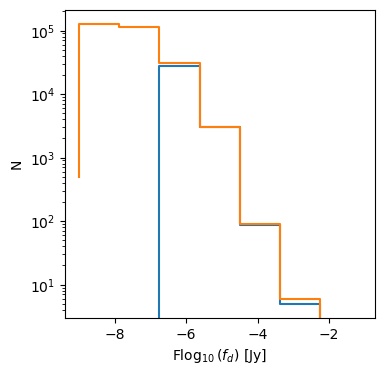

In [8]:
training_catalogue['SURFACE_BRIGHTNESS'] = training_catalogue.apply(calculate_surface_brightness,axis=1)

training_catalogue = training_catalogue[training_catalogue['SURFACE_BRIGHTNESS'] > 127E-9]

training_catalogue[training_catalogue['SELECTION'] == 1]

training_catalogue['AREA_p'] = area(training_catalogue['BMAJ_p'],training_catalogue['BMIN_p']) 
Flux = training_catalogue['FLUX_Tot_corr']

bins = np.linspace(-9,0,9)
plt.figure(figsize=(4,4))
plt.step(bins[:-1],np.histogram(np.log10(Flux),bins)[0])
plt.step(bins[:-1],np.histogram(np.log10(Flux_before),bins)[0])
plt.xlabel('F$\log_{10}(f_{d})$ [Jy]')
plt.ylabel('N')
plt.yscale('log')
plt.show()

(3490, 3490)


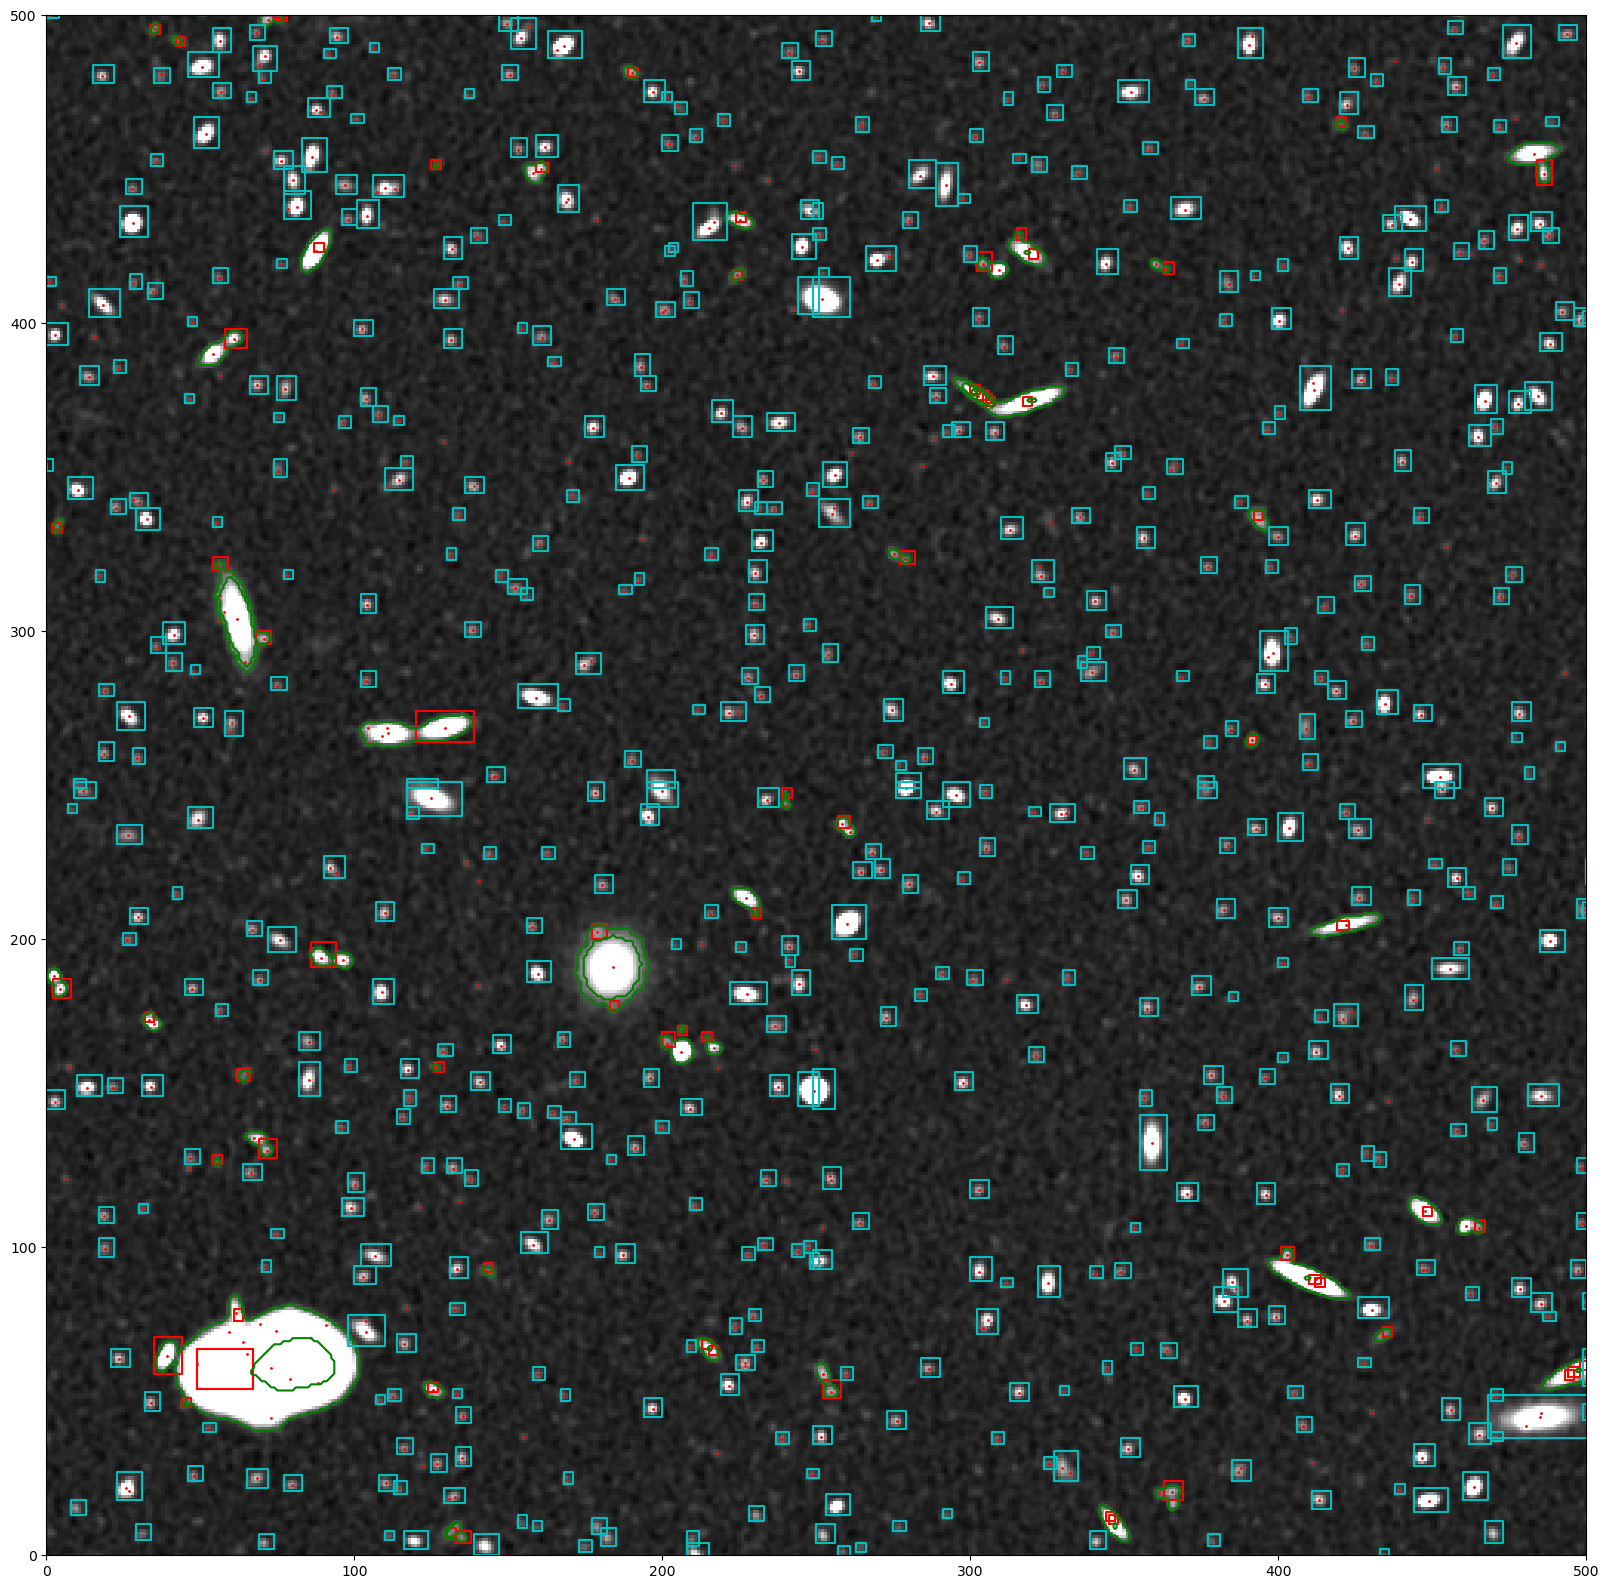

In [9]:
from matplotlib.patches import Ellipse

print(SKA_DC1_TRSF.full_img.shape)
plt.figure(figsize=(20,20))
plt.imshow(SKA_DC1_TRSF.full_img, cmap='gray',vmax=0.00001,origin='lower')
plt.scatter(x=training_catalogue.x, y=training_catalogue.y, c='r', s=1)
#plottings(cat5,'bbox',color='b',img=image)
plottings(cat1,'bbox',color='r',img=image)
plottings(cat2,'polygonwith',color='g',img=image)
plottings(cat3,'bbox',color='y',img=image)
#plottings(cat4,'bbox',color='m',img=image)
plottings(cat0,'bbox',color='c',img=image)
plt.xlim(0,500)
plt.ylim(0,500)
plt.show()

In [10]:
# create unique id for each row thats not the index
listnums = np.arange(0, len(catalogue), 1)

catalogue['id'] = listnums
catalogue.value_counts('id')

id
0        1
20663    1
20631    1
20630    1
20629    1
        ..
10306    1
10305    1
10304    1
10303    1
30932    1
Length: 30933, dtype: int64

In [11]:
from tqdm import tqdm

matched_catalogue = training_catalogue.copy()
matched_catalogue['matched_ids'] = np.nan
matched_catalogue['Flux_tot'] = np.nan
matched_catalogue['dist'] = np.nan
radius = 3

# matching of sources.
for i in tqdm(range(0,len(catalogue)),total=len(catalogue),desc='Matching sources'):
    row = catalogue.iloc[i]
    tag = row.id

    matched_catalogue_cropped = matched_catalogue.copy()
    matched_catalogue_cropped = matched_catalogue_cropped[
        (matched_catalogue_cropped.x > row.x_c - 10) & 
        (matched_catalogue_cropped.x < row.x_c + 10) & 
        (matched_catalogue_cropped.y > row.y_c - 10) & 
        (matched_catalogue_cropped.y < row.y_c + 10)]

    for i in range(len(matched_catalogue_cropped)):
        x = matched_catalogue_cropped.iloc[i].x
        y = matched_catalogue_cropped.iloc[i].y
        #s_p = np.mean([matched_catalogue_cropped.iloc[i].BMAJ_p,matched_catalogue_cropped.iloc[i].BMAJ_p])
        #s = row.area
        #dist_s = abs(s - matched_catalogue_cropped.iloc[i].AREA_p)/matched_catalogue_cropped.iloc[i].AREA_p
        dist = np.sqrt((row.x_c-x)**2 + (row.y_c-y)**2)
        #print(row)
        #print(matched_catalogue_cropped.iloc[i])
        #flux_dist = abs(row.flux_tot - matched_catalogue_cropped.iloc[i].FLUX_Tot_corr)/matched_catalogue_cropped.iloc[i].FLUX_Tot_corr
       # print(flux_dist)
        if dist < radius:
            #if flux_dist < 5:
            #if dist_s < 0.5:

            #print('Matched source ')
            matched_catalogue_cropped.iloc[i,matched_catalogue_cropped.columns.get_loc('matched_ids')] = tag
            matched_catalogue_cropped.iloc[i,matched_catalogue_cropped.columns.get_loc('dist')] = dist
            matched_catalogue_cropped.iloc[i,matched_catalogue_cropped.columns.get_loc('Flux_tot')] = row.flux_tot_corr
        
            matched_catalogue.update(matched_catalogue_cropped,overwrite=False) # prevent double matching assignements. keep the first one.  
                  

Matching sources:   0%|          | 0/30933 [00:00<?, ?it/s]

Matching sources: 100%|██████████| 30933/30933 [02:21<00:00, 219.32it/s]


In [12]:
catalogue

,index,amp,x,y,sigma_x,sigma_y,theta,peak_flux,bbox,Class,...,flux_tot_corr,area,x2,y2,single,polygon,y_c,x_c,Int_flux,id
0,0.0,0.000852,249.235165,150.722589,1.499384,1.344172,-7.679559e-01,0.000826,"[147, 245, 156, 250]",0.0,...,0.000883,39.0,NaN,NaN,NaN,None,151.000000,247.256410,0.010785,0
1,1.0,0.000518,76.129561,61.211708,15.262400,5.914636,7.280715e-02,0.000632,"[41, 36, 85, 102]",2.0,...,0.039008,1840.0,NaN,NaN,NaN,None,61.288043,70.951630,0.293440,1
2,2.0,0.000456,56.512391,60.221102,4.943992,3.329531,-3.966509e-01,0.000392,"[55, 50, 66, 66]",1.0,...,0.005190,118.0,NaN,NaN,NaN,None,60.076271,57.050847,0.047183,2
3,3.0,0.000087,206.458904,163.529941,1.492894,1.283284,-6.012910e+06,0.000077,"[160, 200, 169, 211]",2.0,...,0.000155,61.0,NaN,NaN,NaN,None,164.245902,205.327869,0.001043,3
4,4.0,0.000070,171.295829,135.162042,1.521889,1.056720,4.291651e+06,0.000067,"[133, 168, 139, 176]",0.0,...,0.000103,36.0,NaN,NaN,NaN,None,135.305556,171.361111,0.000704,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2.0,...,0.000047,49.0,107.0,208.0,2.0,"[[3171.5, 3405.0], [3171.5, 3404.0], [3171.5, ...",NaN,NaN,NaN,30928
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2.0,...,0.000035,42.0,95.0,24.0,2.0,"[[3105.5, 3269.0], [3105.0, 3268.5], [3104.5, ...",NaN,NaN,NaN,30929
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2.0,...,0.000032,37.0,157.0,54.0,2.0,"[[3155.5, 3300.0], [3155.5, 3299.0], [3155.0, ...",NaN,NaN,NaN,30930
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2.0,...,0.000011,24.0,58.0,47.0,2.0,"[[3066.5, 3298.0], [3066.5, 3297.0], [3066.0, ...",NaN,NaN,NaN,30931


In [13]:
#for i in range(0,1):
#    tag = catalogue.iloc[i]['id']
#    print(matched_catalogue_cropped)
##    matched_catalogue_cropped = matched_catalogue[matched_catalogue.id == tag]
#    if len(matched_catalogue_cropped) >= 2:
        # keep the one with the lowest dist
#        matched_catalogue_cropped = matched_catalogue_cropped[matched_catalogue_cropped.dist == matched_catalogue_cropped.dist.min()]


In [14]:
# plot flux detected vs True flux

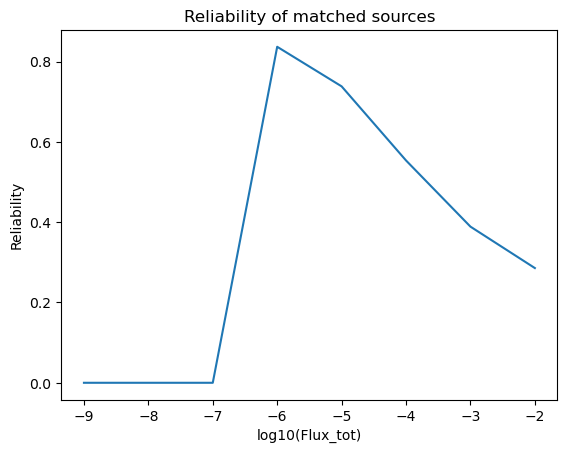

In [15]:
matched_ids = matched_catalogue[['matched_ids','Flux_tot','FLUX_Tot_corr','dist']]
# drop duplicates in matched_ids

matched_ids = matched_ids.drop_duplicates(subset='matched_ids', keep="first")

Flux_matched_2 = matched_ids['FLUX_Tot_corr']
Flux_matched = matched_ids['Flux_tot']

Flux_detected = catalogue['flux_tot_corr']

#Flux_matched = matched_ids['Flux_tot']
# bin by flux_tot
bins = np.linspace(-9,-1,9)
reliability = []
for i in range(len(bins)-1):
    
    # find indexes of flux densities within the bin
    index = (np.log10(Flux_matched) > bins[i]) & (np.log10(Flux_matched) < bins[i+1])
    number_of_matched_sources_in_bin = len(Flux_matched[index])

    index = (np.log10(Flux_matched_2) > bins[i]) & (np.log10(Flux_matched_2) < bins[i+1])
    number_of_matched_sources_in_bin_2 = len(Flux_matched_2[index])
    
    #3print(number_of_matched_sources_in_bin_2)
    #if bins[i] == -6:
    #    number_of_matched_sources_in_bin = number_of_matched_sources_in_bin + number_of_matched_sources_in_bin_2
    
    number_of_detected_source_in_bin = len(Flux_detected[(np.log10(Flux_detected) > bins[i]) & (np.log10(Flux_detected) < bins[i+1])])
    try:
        rel = number_of_matched_sources_in_bin/number_of_detected_source_in_bin
        #if rel > 1:
        #    rel = 1
        reliability.append(rel)   
    except ZeroDivisionError:
        reliability.append(0)

# plot reliability
plt.plot(bins[:-1],reliability)
plt.xlabel('log10(Flux_tot)')
plt.ylabel('Reliability')
plt.title('Reliability of matched sources')
plt.show()




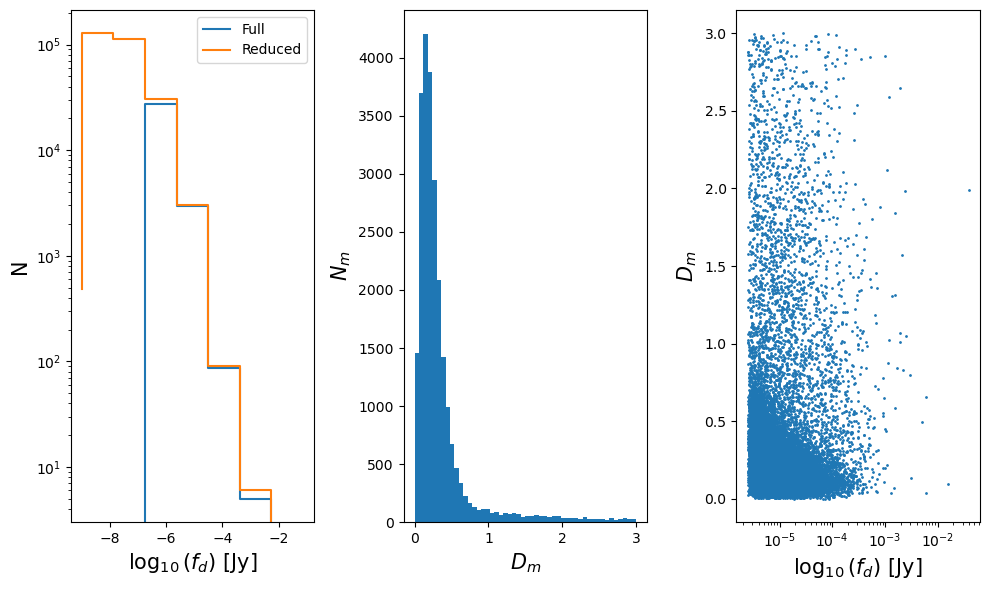

In [16]:
fig, ax = plt.subplots(1,3,figsize=(8, 8))

bins = np.linspace(-9,0,9)
ax[0].step(bins[:-1],np.histogram(np.log10(Flux),bins)[0],label='Full')
ax[0].step(bins[:-1],np.histogram(np.log10(Flux_before),bins)[0],label='Reduced')
ax[0].set_xlabel('$\log_{10}(f_{d})$ [Jy]',fontsize=15)
ax[0].set_ylabel('N',fontsize=15)
ax[0].set_yscale('log')
ax[0].legend(loc='upper right')

matched_ids['dist'].hist(bins=50, figsize=(10, 6),ax=ax[1],grid=False)
ax[1].set_xlabel('$D_{m}$',fontsize=15)
ax[1].set_ylabel('$N_{m}$',fontsize=15)

# plot the distribution of the distances between the matched sources and flux
ax[2].scatter(matched_ids['FLUX_Tot_corr'], matched_ids['dist'], s=1)
ax[2].set_xlabel('$\log_{10}(f_{d})$ [Jy]',fontsize=15)
ax[2].set_ylabel('$D_{m}$',fontsize=15)
ax[2].set_xscale('log')
plt.tight_layout()
plt.show()

In [17]:
print(matched_ids.value_counts('matched_ids'))


matched_ids
0.0        1
20967.0    1
20976.0    1
20975.0    1
20974.0    1
          ..
10713.0    1
10712.0    1
10679.0    1
10674.0    1
30924.0    1
Length: 24515, dtype: int64


In [18]:

#matched_catalogue = training_catalogue.copy()
#matched_catalogue['matched_ids'] = np.nan
#matched_catalogue['dist'] = np.nan
#radius = 5
#i = 147
# matching of sources.
#row = cat1.iloc[i]
#tag = row.id
#print(tag)#
#matched_catalogue_cropped = matched_catalogue.copy()
#matched_catalogue_cropped = matched_catalogue_cropped[
#    (matched_catalogue_cropped.x > row.x_c - 25) & 
#    (matched_catalogue_cropped.x < row.x_c + 25) & 
#    (matched_catalogue_cropped.y > row.y_c - 25) & 
#    (matched_catalogue_cropped.y < row.y_c + 25)]


#for i in range(len(matched_catalogue_cropped)):
#    x = matched_catalogue_cropped.iloc[i].x
#    y = matched_catalogue_cropped.iloc[i].y
#    dist = np.sqrt((x-row.x_c)**2 + (y-row.y_c)**2)
    
#    if dist < radius:
#        print('match found')
#        matched_catalogue_cropped.iloc[i,matched_catalogue_cropped.columns.get_loc('matched_ids')] = tag
#        matched_catalogue_cropped.iloc[i,matched_catalogue_cropped.columns.get_loc('dist')] = dist
                    
#    matched_catalogue.update(matched_catalogue_cropped,overwrite=False)

# check if 0 index is in the list of matched ids
#if 0 not in matched_catalogue.matched_ids.values:
#    print('0 not in matched ids')

    

In [19]:
matched_catalogue.columns

Index(['ID', 'RA_core', 'DEC_core', 'RA_centroid', 'DEC_centroid',
       'FLUX_Tot_corr', 'Core_Frac', 'BMAJ', 'BMIN', 'PA', 'SIZE', 'CLASS',
       'SELECTION', 'x', 'y', 'BMAJ_p', 'BMIN_p', 'SURFACE_BRIGHTNESS',
       'AREA_p', 'matched_ids', 'Flux_tot', 'dist'],
      dtype='object')

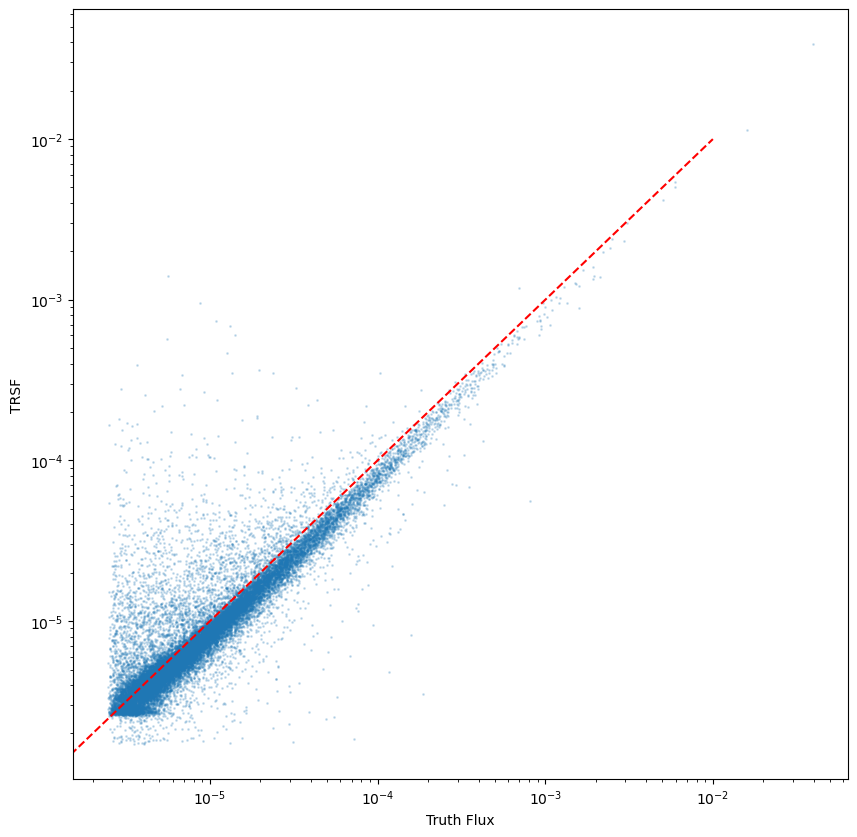

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(matched_catalogue['FLUX_Tot_corr'],matched_catalogue['Flux_tot'],s=1,alpha=0.2)
#plt.hist2d(matched_catalogue['FLUX_Tot_corr'],matched_catalogue['Flux_tot'],bins=100,cmap='viridis')
plt.plot([0,1E-2],[0,1E-2],color='r', linestyle='--')
plt.xlabel('Truth Flux')
plt.ylabel('TRSF')
plt.xscale('log')
plt.yscale('log')
plt.show()

              ID   RA_core   DEC_core  RA_centroid  DEC_centroid  \
121673  22983862 -0.132026 -29.872931    -0.132026    -29.872931   

        FLUX_Tot_corr  Core_Frac   BMAJ   BMIN      PA  ...  SELECTION  \
121673       0.000005       -0.0  0.476  0.166  72.275  ...          1   

              x        y    BMAJ_p    BMIN_p  SURFACE_BRIGHTNESS     AREA_p  \
121673  682.075  416.663  2.604412  2.497575        2.533902e-07  20.435162   

        matched_ids  Flux_tot      dist  
121673       3000.0  0.000006  0.090858  

[1 rows x 22 columns]
    index       amp           x           y   sigma_x   sigma_y     theta  \
91   91.0  0.000005  682.026142  416.608265  0.879863  0.964875 -1.935117   

    peak_flux                  bbox  Class  ...  flux_tot_corr  area  x2  y2  \
91   0.000004  [416, 681, 419, 684]    0.0  ...       0.000006   7.0 NaN NaN   

    single  polygon         y_c    x_c  Int_flux    id  
91     NaN     None  416.714286  682.0  0.000026  3000  

[1 rows x 28 colu

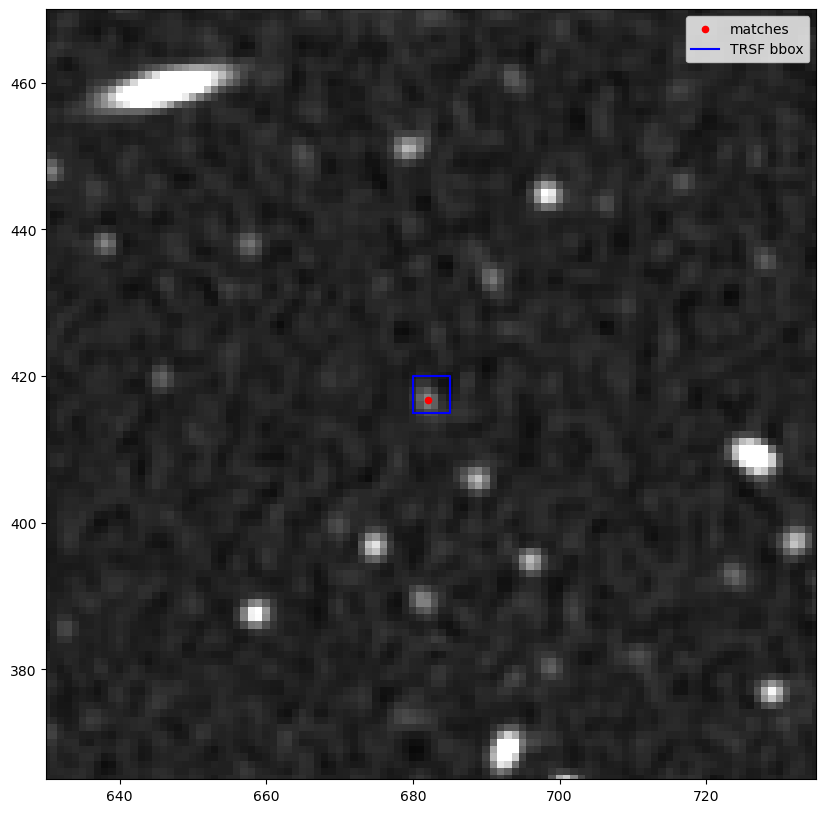

In [21]:
tag = 3000
single_match = matched_catalogue[matched_catalogue['matched_ids']==tag]
plt.figure(figsize=(10,10))
plt.imshow(SKA_DC1_TRSF.full_img, cmap='gray',vmax=0.00001,origin='lower')
plt.scatter(single_match.x, single_match.y, c='r', s=20,label='matches')
bbox = catalogue[catalogue['id']==tag].bbox.values[0]
print(single_match)
print(catalogue[catalogue['id']==tag])
#if bbox != None:
xmin = bbox[0] - 1
xmax = bbox[2] + 1
ymin = bbox[1] - 1    
ymax = bbox[3] + 1
plt.plot([ymin,ymin,ymax,ymax,ymin],[xmin,xmax,xmax,xmin,xmin],color='b',label='TRSF bbox')
plt.xlim(ymin-50, ymax+50)
plt.ylim(xmin-50, xmax+50)
plt.legend()
plt.show()

In [22]:
# calculate the number of matched sources in flux bins.
# flux Int tot | matched num | True num | matched num / True num

Flux_Truth_total = matched_catalogue['FLUX_Tot_corr'].to_numpy()
print(len(Flux_Truth_total))
partial_matched_cat = matched_catalogue.dropna()
Flux_matched_total = partial_matched_cat['FLUX_Tot_corr'].to_numpy()
print(len(Flux_Truth_total))

ssagn_matched_catalogue = matched_catalogue[matched_catalogue['CLASS'] == 1]
Flux_Truth_ssagn = ssagn_matched_catalogue['FLUX_Tot_corr'].to_numpy()
print(len(Flux_Truth_ssagn))
partial_matched_cat = ssagn_matched_catalogue.dropna()
Flux_matched_ssagn = partial_matched_cat['FLUX_Tot_corr'].to_numpy()
print(len(Flux_matched_ssagn))


fsagn_matched_catalogue = matched_catalogue[matched_catalogue['CLASS'] == 2]
Flux_Truth_fsagn = fsagn_matched_catalogue['FLUX_Tot_corr'].to_numpy()
print(len(Flux_Truth_fsagn))
partial_matched_cat = fsagn_matched_catalogue.dropna()
Flux_matched_fsagn = partial_matched_cat['FLUX_Tot_corr'].to_numpy()
print(len(Flux_matched_fsagn))

sfg_matched_catalogue = matched_catalogue[matched_catalogue['CLASS'] == 3]
Flux_Truth_sfg = sfg_matched_catalogue['FLUX_Tot_corr'].to_numpy()
print(len(Flux_Truth_sfg))
partial_matched_cat = sfg_matched_catalogue.dropna()
Flux_matched_sfg = partial_matched_cat['FLUX_Tot_corr'].to_numpy()
print(len(Flux_matched_sfg))

30643
30643
158
149
368
331
30117
25734


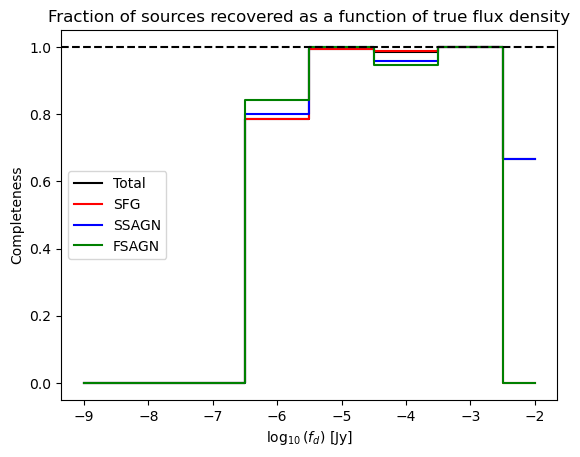

In [23]:
def hist_plot(Flux_Truth,Flux_matched,bins):
    # find the completeness of matched sources in each bin
    Completeness_list = []
    for i in range(len(bins)-1):
        # find indexes of flux densities within the bin
        index = (np.log10(Flux_Truth) > bins[i]) & (np.log10(Flux_Truth) < bins[i+1])
        
        number_of_expected_sources_in_bin = len(Flux_Truth[index])
        # find indexes of matched sources within the bin
        index = (np.log10(Flux_matched) > bins[i]) & (np.log10(Flux_matched) < bins[i+1])
        number_of_matched_source_in_bin = len(Flux_matched[index])
        # find the completeness of matched sources in the bin
        try:
            Completeness_list.append(number_of_matched_source_in_bin/number_of_expected_sources_in_bin)
        except ZeroDivisionError:
            Completeness_list.append(0)
    return Completeness_list, bins
bins = np.linspace(-9,-1,9)
sfg_Completeness_list, sfg_bins = hist_plot(Flux_Truth_sfg,Flux_matched_sfg,bins)
ssagn_Completeness_list, ssagn_bins = hist_plot(Flux_Truth_ssagn,Flux_matched_ssagn,bins)
fsagn_Completeness_list, fsagn_bins = hist_plot(Flux_Truth_fsagn,Flux_matched_fsagn,bins)
total_Completeness_list, total_bins = hist_plot(Flux_Truth_total,Flux_matched_total,bins)
plt.step(total_bins[:-1],total_Completeness_list,where='mid',color='black',label='Total')
plt.step(sfg_bins[:-1],sfg_Completeness_list,where='mid',color='red',label='SFG')
#plt.plot(sfg_bins[:-1],sfg_Completeness_list,color='red')
plt.step(ssagn_bins[:-1],ssagn_Completeness_list,where='mid',color='blue',label='SSAGN')
#plt.plot(ssagn_bins[:-1],ssagn_Completeness_list,color='blue')
plt.step(fsagn_bins[:-1],fsagn_Completeness_list,where='mid',color='green',label='FSAGN')
#plt.plot(fsagn_bins[:-1],fsagn_Completeness_list,color='green')
plt.title("Fraction of sources recovered as a function of true flux density")
plt.axhline(1,linestyle='--',color='black')
plt.xlabel('$\log_{10}(f_{d})$ [Jy]')
plt.ylabel('Completeness')
plt.legend()
plt.show()



In [24]:
print(len(catalogue))
print(len(matched_catalogue.dropna()))

30933
26214


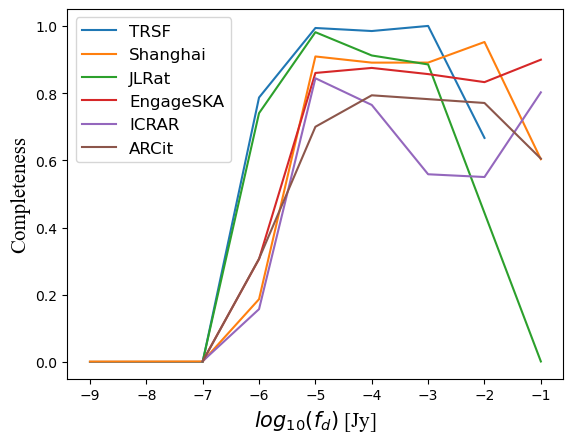

In [25]:
Shanghai_competness = np.array([[-9, 0.0010822335366977853],
    [-7, 0.001391486816969767],
    [-6, 0.1867287212483919],
    [-5, 0.909104924346125],
    [-4, 0.8907424372890325],
    [-3, 0.8908956874308882],
    [-2, 0.9521608728834425],
    [-1, 0.6032396651744404]])

JLRat_competness = np.array([[-7, 0.0013905691514495278],
[-6, 0.7404306604285803],
[-5, 0.9813261184430886],
[-4, 0.9120387010138674],
[-3, 0.8853401403722356],
[-1, 0.0013336738892038014]])

EngageSKA_competness = np.array([[-7, 0.0023174113267452334],
                                 [-6, 0.30617298300942264],
                                [-5, 0.8600309253280272],
                                [-4, 0.8749998852918099],
                                [-3, 0.856634645238157],
                                [-2, 0.8327138581258515],
                                [-1, 0.8995336729715384]])
ICRAR_competness = np.array([[-7, 0.0023183289922652506],
                            [-6, 0.15709913693557787],
                            [-5, 0.8442911263273648],
                            [-4, 0.7648157862940536],
                            [-3, 0.5584869530904678],
                            [-2, 0.5503105533064251],
                            [-1, 0.8023143524416784]])
ARCit_competness = np.array([[-7, 0.001391486816969767],
                            [-6, 0.30709707218815807],
                            [-5, 0.6998450674713573],
                            [-4, 0.7935185284315719],
                            [-2, 0.7706787513019377],
                            [-1, 0.6050915141939913]])

plt.plot(total_bins[:-1],total_Completeness_list,label='TRSF')
plt.plot(Shanghai_competness[:,0],Shanghai_competness[:,1],label='Shanghai')
plt.plot(JLRat_competness[:,0],JLRat_competness[:,1],label='JLRat')
plt.plot(EngageSKA_competness[:,0],EngageSKA_competness[:,1],label='EngageSKA')
plt.plot(ICRAR_competness[:,0],ICRAR_competness[:,1],label='ICRAR')
plt.plot(ARCit_competness[:,0],ARCit_competness[:,1],label='ARCit')
plt.legend(fontsize=12)
plt.xlabel('$log_{10}(f_{d})$ [Jy]',fontsize=15,font='Times New Roman')
plt.ylabel('Completeness',fontsize=15,font='Times New Roman')
plt.show()

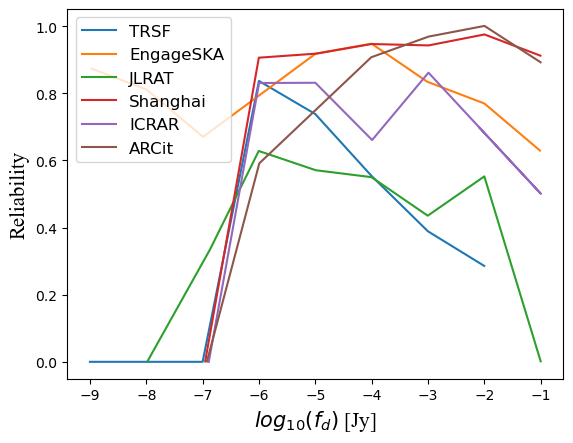

In [26]:
EngageSKA_Rel = np.array([[-8.971913996417303, 0.8736660982730755],
[-7.994662979401175, 0.8112708881278895],
[-6.991647778182438, 0.6701845136195678],
[-4.992645440206588, 0.9183403535439557],
[-3.999022533563383, 0.9477467446395865],
[-3.011592940430422, 0.8345308194763557],
[-1.997564412143472, 0.7696728247500968],
[-1.010312540180804, 0.6294077374681333]])


JLRAT_Reli = np.array([[-7.978958890535204, 0.0014332135286203584],
[-6.867700725627461, 0.3349259124871339],
[-6.003749647418702, 0.6282800158602683],
[-4.989672649721672, 0.5707990653482092],
[-4.001634496217703, 0.5502060286521534],
[-3.003703197567374, 0.4353496832322097],
[-1.9989915669958318, 0.5524598562208807],
[-0.9986691107815506, 0.0015376920347929257]
])

Shanghai_Reli = np.array([[-6.953992432040166, 0.001328196473446619],
[-6.001923966305682, 0.9061486812617937],
[-4.97687672546051, 0.918338737896953],
[-4.004284157302085, 0.9469276116092319],
[-2.9898571027544776, 0.9427253137552823],
[-1.9962126541512362, 0.9754103911683353],
[-1.003198307879039, 0.912193893796791]])

ICRAR_Reli = np.array([[-6.890928344035874, -0.00031760927327528776],
[-5.99716319313781, 0.8307383574120839],
[-4.998472540396224, 0.8314557046812702],
[-3.9903949785691157, 0.6608606147671485],
[-2.9903902662653596, 0.8615778273990846],
[-0.9953893473661264, 0.5007176838623121],
[-2.082143532733344, 0.6967306709714687]])

ARCit_Reli = np.array([[-6.922455002548011, 0.00132496517944114],
[-5.993479517971717, 0.5913937176912676],
[-4.004542660822513, 0.9075833758001663],
[-2.9896847670741913, 0.9689548042946594],
[-1.9960457039609611, 1.0008202101283568],
[-1, 0.8925212373432574]])


plt.plot(bins[:-1],reliability,label='TRSF')
plt.plot(EngageSKA_Rel[:,0],EngageSKA_Rel[:,1],label='EngageSKA')
plt.plot(JLRAT_Reli[:,0],JLRAT_Reli[:,1],label='JLRAT')
plt.plot(Shanghai_Reli[:,0],Shanghai_Reli[:,1],label='Shanghai') 
plt.plot(ICRAR_Reli[:,0],ICRAR_Reli[:,1],label='ICRAR')
plt.plot(ARCit_Reli[:,0],ARCit_Reli[:,1],label='ARCit')
plt.legend(loc='upper left',fontsize=12)
plt.xlabel('$log_{10}(f_{d})$ [Jy]',fontsize=15,font='Times New Roman')
plt.ylabel('Reliability',fontsize=15,font='Times New Roman')
plt.show()




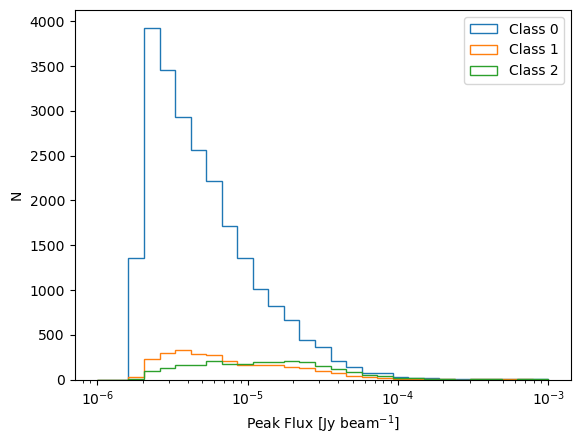

In [67]:
Peak_flux_class0 = catalogue[catalogue['Class']==0]
Peak_flux_class1 = catalogue[catalogue['Class']==1]
Peak_flux_class2 = catalogue[catalogue['Class']==2]
bins = np.logspace(-6,-3,30)
plt.hist(Peak_flux_class0['peak_flux'],bins=bins,label='Class 0',histtype='step')
plt.hist(Peak_flux_class1['peak_flux'],bins=bins,label='Class 1',histtype='step')
plt.hist(Peak_flux_class2['peak_flux'],bins=bins,label='Class 2',histtype='step')
plt.xscale('log')
plt.xlabel('Peak Flux [Jy beam$^{-1}$]')
plt.ylabel('N')
plt.legend()
plt.show()

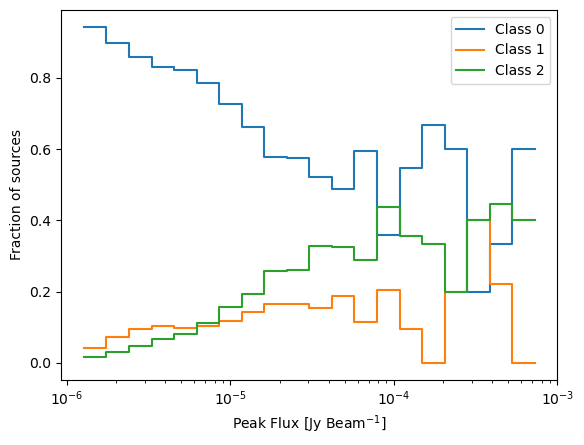

In [65]:
# distribution of pek flux per class
Peak_flux_class0 = catalogue[catalogue['Class']==0]
Peak_flux_class1 = catalogue[catalogue['Class']==1]
Peak_flux_class2 = catalogue[catalogue['Class']==2]
bins = np.logspace(-7,-3,30)
# normalisze by the number of sources in each class

data0 = np.histogram(Peak_flux_class0['peak_flux'],bins=bins)
data1 = np.histogram(Peak_flux_class1['peak_flux'],bins=bins)
data2 = np.histogram(Peak_flux_class2['peak_flux'],bins=bins)

totaldata = np.histogram(catalogue['peak_flux'],bins=bins)

data0 = data0[0]/totaldata[0]
data1 = data1[0]/totaldata[0]
data2 = data2[0]/totaldata[0]

plt.step(bins[:-1],data0,label='Class 0')
plt.step(bins[:-1],data1,label='Class 1')
plt.step(bins[:-1],data2,label='Class 2')

#plt.hist(Peak_flux_class2['peak_flux'],bins=bins, label='Class 2',density=True,histtype='step')
##plt.hist(Peak_flux_class1['peak_flux'],bins=bins, label='Class 1',density=True,histtype='step')

plt.xscale('log')
#plt.yticks([])
#plt.xlim(0.5E-6,1E-3)
plt.xlabel('Peak Flux [Jy Beam$^{-1}$]')
plt.ylabel('Fraction of sources')
plt.legend()
plt.show()